# Assignment 2


## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `FirstnameLastname.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it by adding the source of the code as a comment in the first line of the code cell.
- In real life clients can give unclear goals or requirements. So, if the instructions seem vague, use common sense to make reasonable assumptions.

# Task 1: [Where's Waldo?](https://www.wikihow.com/Find-Waldo) (35 points)

## Fingerprinting
Browser fingerprinting is a technique used to identify and track individuals based on unique characteristics of their web browser configuration. These characteristics can include the browser type, version, installed plugins, and screen resolution, among others. By combining these attributes, websites can create a digital fingerprint that can be used to track user behavior across multiple sites, even if they clear their cookies or use different devices. This has raised concerns about privacy and the potential for this technology to be used for targeted advertising, surveillance, and other purposes.

[Read more]([Fingerprinting](https://datadome.co/learning-center/browser-fingerprinting-techniques/))

##  What you need to do
For this task, you are required to build a fully connect feed-forward ANN model
for a classification problem.

For the given data, you need do proper data preprocessing, data analysis,
design the ANN model, then fine-tune your model architecture.

For evaluating your model, do $ 80/20 $ train test split.

### Learning Objectives

- Select and implement suitable data preprocessing techniques. 10%
- Identify the appropriate classification approach for a given problem. 20%
- Apply ANNs to solve a classification problem (basic training, validation, testing -- without fine tuning). 50%
- Fine-tune to determine the optimal model architecture. 20%


### Data
You will be working with the data in `Task_1.csv` for identifying waldo (the user with `user_id=0`) 

The columns include:
 - browser
 - os
 - locale
 - user_id
 - gender
 - location
 - sites
 - time
 - date

After training, evaluate you model by print [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
on your test set. 

Then predicting each user in `task_1_verify.csv` whether it's Waldo or not. Your output should look like the following:

`row_idx: is_waldo`, notice if the user is waldo your output should be 1

``` 
0: 1
1: 0
2: 0
3: 1
4: 1
...
```



In [14]:
import pandas as pd

data = pd.read_csv('task 1.csv')

# We can immediately drop index column, since all of its values are unique
data = data.drop('index', axis=1)

data['is_waldo'] = pd.Series(map(float, data['user_id'] == 0))

# Since we only need user_id to determine waldo, we no longer need
# user_id column after making is_waldo
data = data.drop('user_id', axis=1)

data.head()

,browser,os,locale,location,sites,time,date,is_waldo
0,Firefox,Windows 10,zh-CN,China/Shanghai,"[{'site': '1.static.dpreview.com', 'length': 1...",14:14:00,2016-01-28,0.0
1,Internet Explorer,Windows 8,ro-RO,Germany/Berlin,"[{'site': 'safebrowsing-cache.google.com', 'le...",05:23:00,2016-08-26,0.0
2,Internet Explorer,MacOS,ur-PK,Australia/Sydney,"[{'site': 'www.ncbi.nlm.nih.gov', 'length': 10...",12:03:00,2016-03-13,0.0
3,Internet Explorer,Ubuntu,pl-PL,Japan/Tokyo,"[{'site': 'fr.hdscreen.me', 'length': 16}, {'s...",06:08:00,2017-01-19,0.0
4,Internet Explorer,Windows 8,bg-BG,Japan/Tokyo,"[{'site': '193.164.196.50', 'length': 10}, {'s...",03:59:00,2017-05-13,0.0


## Processing time and date

Since `time` and `date` columns are of high cardinality, we should process them differently. Instead of using each `date` directly, we will retransform this column and only use the day of the week of this date. Similarly, instead of using `time` directly, we will use it to determine the part of the day when the user is active: [early morning, late morning, early afternooon, late afternoon, early evening, late evening, night] -> [0, 1, 2, 3, 4, 5, 6].

In [15]:
import datetime

def change_date(row):
    day, month, year = map(int, row.date.split('-'))
    date = datetime.datetime(day, month, year)
    row.date = float(date.weekday())
    return row

def change_time(row):
    hour, minute, second = map(int, row.time.split(':'))
    # Early morning
    if 4 <= hour < 9:     row.time = 0.
    # Late morning
    elif 9 <= hour < 12:  row.time = 1.
    # Early afternoon
    elif 12 <= hour < 15: row.time = 2.
    # Late afternoon
    elif 15 <= hour < 17: row.time = 3.
    # Early evening
    elif 17 <= hour < 19: row.time = 4.
    # Late evening
    elif 19 <= hour < 22: row.time = 5.
    # Night
    elif 22 <= hour <= 23 or 0 <= hour < 4:  row.time = 6.

    return row

## Processing sites
`sites` column has the highest cardinality among all other non-dropped columns, because for each user the sequence of visited sites and the time spent on them is unique. To make use of this column, we have to find similarities between all entries. By analyzing some of the data, I came to the conclusion that we should keep only the second level domain of sites with the most amount of occurrences per user.

In [16]:
from collections import Counter
import json
import ast

def change_sites(row):
    sld = Counter([s['site'].split('.')[-2] for s in ast.literal_eval(row.sites)])
    row.sites = sld.most_common(1)[0][0]
    return row

## Finally processing all data and encoding categorically using OneHotEncoder

In [17]:
from sklearn.preprocessing import OneHotEncoder

def OHE(df, features, encoder):
    new_features = encoder.transform(df[features])

    new_columns = pd.DataFrame(new_features, columns=encoder.get_feature_names_out(features))
    new_df = pd.concat([df, new_columns], axis=1)
    # dropping initial columns after performing OHE on them
    new_df.drop(features, axis=1, inplace=True)
        
    return new_df


def process_data(data):
    data = data.apply(change_date, axis='columns')
    data = data.apply(change_time, axis='columns')
    data = data.apply(change_sites, axis='columns')
    
    encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
    features = ['browser', 'os', 'locale', 'location', 'sites']

    if set(features).issubset(set(data.columns)):
        encoder.fit(data[features])
        data = OHE(data, features, encoder)
    
    return data


In [18]:
data = process_data(data)
data

,time,date,is_waldo,browser_Firefox,browser_Internet Explorer,browser_Safari,os_MacOS,os_Ubuntu,os_Windows 10,os_Windows 7,...,sites_zara,sites_zcache,sites_zegive,sites_zepass,sites_zonebourse,sites_zongheng,sites_zopim,sites_ztat,sites_zurb,sites_zvon
0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20396,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20397,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20398,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20399,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
from sklearn.model_selection import train_test_split

X = data.drop('is_waldo', axis=1)
y = data['is_waldo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Applying ANN

In [20]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses

dim = X_train.shape[1]

model = keras.Sequential(
    [
        layers.Dense(256, activation='relu', input_dim=dim),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model.summary()

Model: "sequential_5"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 dense_17 (Dense)            (None, 256)               436480    

                                                                 

 dense_18 (Dense)            (None, 128)               32896     

                                                                 

 dense_19 (Dense)            (None, 1)                 129       

                                                                 


Total params: 469,505

Trainable params: 469,505

Non-trainable params: 0

_________________________________________________________________


In [27]:
from keras import backend as K

batch_size = 64
epochs = 30


# Custom recall, precision and f1 metrics
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0., 1.)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0., 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0., 1.)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0., 1.)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * ((prec * rec) / (prec + rec + K.epsilon()))


# We use binary crossenrtopy here because our target is a binary class
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[keras.metrics.BinaryAccuracy(), f1, precision, recall])

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/30

230/230 [==============================] - 2s 7ms/step - loss: 6.2911e-04 - f1: 0.6855 - precision: 0.6859 - recall: 0.6855 - binary_accuracy: 0.9999 - val_loss: 0.0141 - val_f1: 0.6923 - val_precision: 0.6923 - val_recall: 0.7115 - val_binary_accuracy: 0.9982

Epoch 2/30

230/230 [==============================] - 1s 6ms/step - loss: 2.7515e-04 - f1: 0.7029 - precision: 0.7022 - recall: 0.7043 - binary_accuracy: 0.9999 - val_loss: 0.0136 - val_f1: 0.6923 - val_precision: 0.6923 - val_recall: 0.7115 - val_binary_accuracy: 0.9982

Epoch 3/30

230/230 [==============================] - 1s 6ms/step - loss: 1.7011e-04 - f1: 0.6855 - precision: 0.6870 - recall: 0.6848 - binary_accuracy: 0.9999 - val_loss: 0.0160 - val_f1: 0.7051 - val_precision: 0.6923 - val_recall: 0.7308 - val_binary_accuracy: 0.9988

Epoch 4/30

230/230 [==============================] - 1s 6ms/step - loss: 3.0698e-04 - f1: 0.7217 - precision: 0.7217 - recall: 0.7217 - binary_accuracy: 0.9999 - val_loss: 0.01

In [28]:
score = model.evaluate(X_test, y_test, verbose=0)
score

[0.003301817923784256, 0.484375, 0.484375, 0.484375, 0.9995099306106567]

In [29]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = np.round(model.predict(X_test))
print(classification_report(y_test, y_pred))

128/128 [==============================] - 0s 2ms/step

              precision    recall  f1-score   support



         0.0       1.00      1.00      1.00      4001

         1.0       0.98      1.00      0.99        80



    accuracy                           1.00      4081

   macro avg       0.99      1.00      0.99      4081

weighted avg       1.00      1.00      1.00      4081




## Fine-tuning model

In [30]:
model1 = keras.Sequential(
    [
        layers.Dense(128, activation='relu', input_dim=dim),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model2 = keras.Sequential(
    [
        layers.Dense(32, activation='relu', input_dim=dim),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model3 = keras.Sequential(
    [
        layers.Dense(512, activation='relu', input_dim=dim),
        layers.Dense(1, activation='sigmoid')
    ]
)

model4 = keras.Sequential(
    [
        layers.Dense(32, activation='relu', input_dim=dim),
        layers.Dense(64, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

models = [model, model1, model2, model3, model4]
best_f1 = 0.
best_model = None

for m in models:
    m.compile(loss="binary_crossentropy", optimizer="adam", metrics=[keras.metrics.BinaryAccuracy(), f1, precision, recall])
    m.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
    
    y_pred = np.round(m.predict(X_test))
    
    f1_score = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
    
    if f1_score >= best_f1:
        best_f1 = f1_score
        best_model = m

print('Best F1 score:', best_f1)
best_model.summary()

128/128 [==============================] - 0s 2ms/step

128/128 [==============================] - 0s 2ms/step

128/128 [==============================] - 0s 1ms/step

128/128 [==============================] - 0s 2ms/step

128/128 [==============================] - 0s 1ms/step

Best F1 score: 0.9997557076936715

Model: "sequential_9"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 dense_30 (Dense)            (None, 32)                54560     

                                                                 

 dense_31 (Dense)            (None, 64)                2112      

                                                                 

 dense_32 (Dense)            (None, 16)                1040      

                                                                 

 dense_33 (Dense)            (None, 1)                 17        

                                                          

## Verifying data

In [31]:
verify_data = process_data(pd.read_csv('task_1_verify.csv'))

merged_data = pd.merge(pd.DataFrame(columns=data.columns), verify_data, how='outer').drop('is_waldo', axis=1)

og_columns_order = data.drop('is_waldo', axis=1).columns
merged_data = merged_data[og_columns_order].fillna(0.)

In [34]:
y_verif = np.round(best_model.predict(merged_data))

for idx, prediction in enumerate(y_verif):
    print(f"{idx}: {int(prediction[0])}")

2/2 [==============================] - 0s 2ms/step

0: 0

1: 0

2: 0

3: 0

4: 0

5: 0

6: 0

7: 0

8: 0

9: 0

10: 0

11: 0

12: 0

13: 0

14: 0

15: 0

16: 0

17: 0

18: 0

19: 0

20: 0

21: 0

22: 0

23: 0

24: 0

25: 0

26: 0

27: 0

28: 0

29: 0

30: 0

31: 1

32: 1

33: 1

34: 1

35: 1


### Questions
1. Did you find any usefull insights from your data analysis?
    - Apparently, even without using `sites` column we can get fairly high accuracy (~0.98). This was pretty surprising because I thought this will be the column with the most impact on the predictions.
2. What preprocessing techniques did you use? Why?
    - As described earlier, feature selection (by dropping redundant `index` and `user_id` columns), data transformation (by modifying columns with the highest cardinality: `time`, `date` and `sites`)
3. Describe the fine-tuning process and how you reached your model architecture.
    - In the fine-tuning process I tried several models with different layer architecture to chose the best among them based on F1-score and accuracy metrics.
4. Which metric did you try to optemize for this task? Why?
    - Since dataset is imbalanced, the most appropriate metric here is F1-score, along with the binary accuracy metric.

# Task 2: Fingerprint Recognition (50 points)
Fingerprint recognition is a highly accurate and reliable biometric technology that is used for identification and authentication purposes. By analyzing the unique patterns and ridges on an individual's fingerprint, it is possible to verify their identity with a high degree of confidence. This technology is widely used in law enforcement, border control, and access control systems, as well as in mobile devices and payment systems, to ensure secure and reliable identification and authentication.

In this task you will be doing a simplified version of Fingerprint ID, which is just identifying which finger is used in the image

## What you need to do

For this task, you will be doing image classification:
- Build a CNN model for image classification.
- Estimate the speed of inference of your model

For the given data, you need to do proper data preprocessing, augmentation, and data loaders.

Then fine-tune your model architecture to achieve the highest accuracy.

### Learning Objectives

- Select and implement suitable data preprocessing techniques. 10%
- Use literature (any paper on the use of CNN for fingerprinting and cite it) to choose an architecture. 10%
- Apply CNNs to solve an image classification problem (basic training, validation, testing -- without fine tuning). 40%
- Fine-tune your model to improve performance. 20%
- Use of data augmentation to improve model’s performance. 20%
- Explore beyond data augmentation find techniques to improve model’s performance and use them. 15%(bonus)


### Data
You will be working with the data in `task_2.zip` for image classification. Download [link](https://drive.google.com/file/d/1iMIdYKSmCjVL5p-yzy-oInLMtTVt-1_j/view?usp=share_link)

The name of each image consists of 2 parts like `idx_label.BMB`, where the idx is the index of the image and the label is the target class.

Each label corresponds to a finger:
```
0-> left_thumb
1-> left_index
2-> left_middle
3-> left_ring
4-> left_little
5-> right_thumb
6-> right_index
7-> right_middle
8-> right_ring
9-> right_little
```

In [1]:
import pathlib

class_names = ['left_thumb', 'left_index', 'left_middle', 
               'left_ring', 'left_little', 'right_thumb',
               'right_index', 'right_middle', 'right_ring', 
               'right_little']

def prepare_dataset(directory, bmp=True):
    directory = pathlib.Path(directory)
    
    # Creating directory for each class
    for i in range(len(class_names)):
        path = directory / class_names[i]
        try:
            path.mkdir(parents=True, exist_ok=False)
        except FileExistsError:
            print(f'Folder {class_names[i]} already exists')
    
    images = directory.rglob('*.bmp') if bmp else directory.iterdir()
    for image in images:
        # Taking into account only files in main directory and not subdirectories
        if image.is_dir() or (image.parent != directory and not image.parent.name[0].isdigit()):
            continue
        
        if bmp:
            idx, label = map(int, image.name.split('.')[0].split('_'))
        else:
            idx, label = map(int, image.name.split('_'))
        
        # Moving files to their according class directory by label
        try:
            image.rename(directory / class_names[label] / f'{label}_{idx}.bmp')
        except IndexError:
            print('Invalid filename', image.name)


In [3]:
from PIL import Image
from collections import Counter
import pathlib


def get_image_sizes(directory, bmp=True):
    directory = pathlib.Path(directory)
    
    images = directory.rglob('*.bmp') if bmp else directory.iterdir()
    img_sizes = []
    
    for image in images:
        if not image.is_dir():
            try:
                with Image.open(image) as im:
                    img_sizes.append(im.size)
            except FileNotFoundError:
                print('Not found:', image.name)
    
    return Counter(img_sizes)

In [31]:
from tensorflow import keras
import pathlib
import os

# train_dir = pathlib.Path('D:\\train').absolute().__str__()
train_dir = '/kaggle/input/fingerprint-classification/train/train'
# sizes = get_image_sizes(train_dir)
# prepare_dataset(train_dir)

batch_size = 64
# Selecting image size as the most common size of images from the training set
# image_size = sizes.most_common(1)[0][0]
image_size = (96, 103)

train_dataset = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    image_size=image_size,
    batch_size=batch_size,
    subset='training',
    validation_split=0.2,
    seed=123,
    class_names=class_names
)

validation_dataset = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    image_size=image_size,
    batch_size=batch_size,
    subset='validation',
    validation_split=0.2,
    seed=123,
    class_names=class_names
)

train_dataset

Found 19413 files belonging to 10 classes.
Using 15531 files for training.
Found 19413 files belonging to 10 classes.
Using 3882 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 96, 103, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Visualising the data

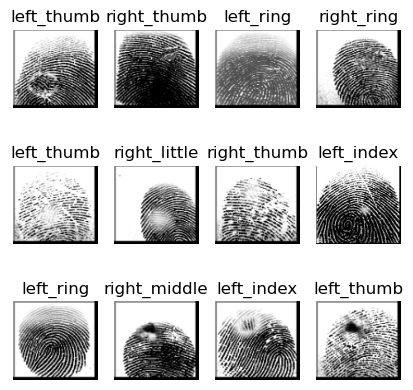

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Applying CNN

In [34]:
import tensorflow as tf
import numpy as np

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
def evaluate_model(model, train_dataset, validation_dataset, epochs, verbose=False):
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

    model.compile(
        optimizer='adam',
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        callbacks=[early_stopping],
        batch_size=batch_size,
        epochs=epochs,
        verbose=int(verbose)
    )
    
    return history.history, model

In [36]:
num_classes = len(class_names)
input_shape = (*image_size, 3)

# Model from Lab 9
model = keras.Sequential([
    keras.layers.Rescaling(1./255),
    
    keras.Input(shape=input_shape),
    
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(num_classes, activation="softmax"),
])
model._name = 'lab9_model'

history = evaluate_model(
    model, 
    train_dataset, 
    validation_dataset, 
    epochs=30, 
    verbose=True
)[0]

print('Train accuracy of the model:', history['accuracy'][-1])

Epoch 1/30
243/243 [==============================] - 13s 47ms/step - loss: 1.4950 - accuracy: 0.4645 - val_loss: 1.1719 - val_accuracy: 0.5788
Epoch 2/30
243/243 [==============================] - 3s 14ms/step - loss: 1.0153 - accuracy: 0.6435 - val_loss: 0.9966 - val_accuracy: 0.6422
Epoch 3/30
243/243 [==============================] - 3s 12ms/step - loss: 0.7350 - accuracy: 0.7566 - val_loss: 0.7822 - val_accuracy: 0.7138
Epoch 4/30
243/243 [==============================] - 3s 12ms/step - loss: 0.4662 - accuracy: 0.8607 - val_loss: 0.5423 - val_accuracy: 0.8145
Epoch 5/30
243/243 [==============================] - 3s 12ms/step - loss: 0.2869 - accuracy: 0.9223 - val_loss: 0.4378 - val_accuracy: 0.8586
Epoch 6/30
243/243 [==============================] - 3s 12ms/step - loss: 0.1696 - accuracy: 0.9585 - val_loss: 0.4471 - val_accuracy: 0.8534
Epoch 7/30
243/243 [==============================] - 3s 12ms/step - loss: 0.1068 - accuracy: 0.9760 - val_loss: 0.3094 - val_accuracy: 0.910

## Fine-tuning the model
By reading some of the articles about image recognition and classification articles, I stumbled upon AlexNet CNN, which appears to be pretty simple and at the same time gives good results. However, it came out that just by running this model my PC just dies without even running one epoch :) (i don't have GPU). So, I will leave that model here but not consider it in the fine-tunning process, where I will chose some other simpler models for evaluation.

In [38]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (227, 227))
    return image, label


train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
validation_dataset_size = tf.data.experimental.cardinality(validation_dataset).numpy()

try:
    alexnet_train_dataset = (train_dataset.map(process_images)
                             .shuffle(train_dataset_size))

    alexnet_validation_dataset = (validation_dataset.map(process_images)
                                  .shuffle(validation_dataset_size))
except Exception as E:
    print(train_dataset)


alexnet_model = keras.Sequential([
    
    keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                        activation='relu', input_shape=(227, 227, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2,2)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), 
                        activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1),
                        activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), 
                        activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), 
                        activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

alexnet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                      

In [39]:
# Model from tensorflow tutorial
model1 = keras.Sequential([
    keras.layers.Rescaling(1./255),
    
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])
model1._name = 'tf_tutorial'

model2 = keras.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(512, kernel_size=(5, 5), padding='same', activation='relu'),
    keras.layers.Conv2D(512, kernel_size=(5, 5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(4, 4)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(num_classes, activation='softmax')
])
model2._name = 'some_random_model'
# model2.build((None, *input_shape))

print()

models = [model2, model, model1]
best_val_acc = 0.
best_model = None

for m in models:
    evaluation = evaluate_model(m, train_dataset, validation_dataset, epochs=30)
    # Chosing a model based on a validation accuracy
    history = evaluation[0]
    val_acc = history['val_accuracy'][-1]
    print(f'Model {m.name} validation accuracy {val_acc} achieved in {len(history["accuracy"])} epochs')
    print('Train acc:', history['accuracy'][-1])
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = evaluation[1]

if best_model is not None:
    print()
    best_model.summary()

2023-04-16 11:03:16.213831: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insome_random_model/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Model some_random_model validation accuracy 0.9108706712722778 achieved in 30 epochs
Train acc: 0.9398621916770935
Model lab9_model validation accuracy 0.9314786195755005 achieved in 8 epochs
Train acc: 0.9963299036026001
Model tf_tutorial validation accuracy 0.8078309893608093 achieved in 11 epochs
Train acc: 0.9344536662101746

Model: "lab9_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 96, 103, 3)        0         
                                                                 
 input_6 (InputLayer)        multiple                  0         
                                                                 
 conv2d_10 (Conv2D)          (None, 94, 101, 32)       896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 47, 50, 32)       0         
 g2D)                                                 

## Augmenting the dataset
After trying some different combinations of transformations, only `RandomContrast` layer yielded better results than dataset without any transformations. This is probably because after doing rotations or shifts, there is a higher chance that the model will think that this particular finger corresponds to the opposite hand.

In [40]:
def augment_dataset(dataset):
    transformations = tf.keras.Sequential([
        # keras.layers.RandomRotation(factor=0.1),
        keras.layers.RandomContrast(factor=0.15),
        # keras.layers.RandomBrightness(factor=0.2)
        #keras.layers.RandomTranslation(height_factor=0.1,
        #                               width_factor=0.1,
        #                               fill_mode='reflect')
    ])
    
    dataset = dataset.map(lambda x, y: (transformations(x, training=True), y),
                          num_parallel_calls=AUTOTUNE)
    
    return dataset.prefetch(buffer_size=AUTOTUNE)


augmented_train_dataset = augment_dataset(train_dataset)
augmented_train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 103, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [41]:
evaluation_normal = evaluate_model(best_model, train_dataset, validation_dataset, epochs=30)
history_normal_ds = evaluation_normal[0]
normal_ds_acc = history_normal_ds["val_accuracy"][-1]
print(f'Normal dataset validation accuracy: {normal_ds_acc}. Epochs: {len(history_normal_ds["accuracy"])}')

evaluation_augmented = evaluate_model(best_model, augmented_train_dataset, validation_dataset, epochs=30)
history_augmented_ds = evaluation_augmented[0]
augmented_ds_acc = history_augmented_ds["val_accuracy"][-1]
print(f'Augmented dataset validation accuracy: {augmented_ds_acc}. Epochs: {len(history_augmented_ds["accuracy"])}')

# If augmented dataset yields better accuracy, we switch to this fitted model
best_model = evaluation_normal[1] if normal_ds_acc > augmented_ds_acc else evaluation_augmented[1]

Normal dataset validation accuracy: 0.9489953517913818. Epochs: 5
Augmented dataset validation accuracy: 0.9636785387992859. Epochs: 5


## Evaluating the model on the test dataset

In [42]:
import numpy as np

# test_dir = pathlib.Path('C:\\test').absolute().__str__()
test_dir = '/kaggle/input/fingerprint-classification/test/test'

# prepare_dataset(test_dir, bmp=False)

test_dataset = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    image_size=image_size,
    batch_size=batch_size,
    class_names=class_names
)

score = best_model.evaluate(test_dataset)
score

Found 14272 files belonging to 10 classes.
223/223 [==============================] - 7s 31ms/step - loss: 0.4892 - accuracy: 0.9067


[0.48915258049964905, 0.9067404866218567]

### Questions
1. What preprocessing techniques did you use? Why?
    - I restructured initial data to generate `tf.data.Dataset` to conviniently transform images (rescale, reshape, augment) to then pass it to the model.
2. What data augmentation techniques did you use?
    - I used only `keras.layers.RandomContrast` (was described earlier why).
3. Describe the fine-tuning process and how you reached your final CNN model.
    - In the fine-tuning process I tried several different models with different parameters for evaluation (batch size, number of epochs, patience of the early stopping, validation set sizes).
4. What techniques did you use to improve model’s performance other than data augmentation
    - I used early stopping on validation accuracy to prevent overfitting.

# Task 3: Credit approval (15 points)

Credit approval is necessary to assess an individual's creditworthiness and determine their eligibility for loans, credit cards, and other financial products. It helps lenders to evaluate the borrower's ability to repay the loan, their credit history, and other financial obligations.
Credit approval is important for both lenders and borrowers because it enables lenders to manage their risk and make informed lending decisions while ensuring that borrowers can obtain financing on fair and reasonable terms.

In many credit approval applications, it is crucial for the model to be interpretable. This means that the model's inner workings and decision-making process can be easily understood and explained by humans. An interpretable model can help to build trust in the model's output, provide transparency in the decision-making process, and enable regulators to monitor and audit the model's performance. 

## What you need to do

For the `loan_data.csv` data, predict if the bank should give a loan or not.

- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Learning Objectives

- Apply DTs, and RFs to solve a classification problem (basic training, validation, testing. 50%
- Fine-tune to determine the optimal model architecture. 20%
- Evaluate and compare the performance of different models. 10%
- Visualise the models. 20%


### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

In [19]:
import pandas as pd

data = pd.read_csv('/kaggle/input/loan-data/loan_data.csv')

X = data.drop('credit.policy', axis=1)
y = data['credit.policy']

# y.value_counts()
X.purpose.value_counts()

debt_consolidation    3957
all_other             2331
credit_card           1262
home_improvement       629
small_business         619
major_purchase         437
educational            343
Name: purpose, dtype: int64

### Splitting the data

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

def find_missing_data_columns(frame):
    return [column for column in frame.columns if frame[column].isnull().any()]

find_missing_data_columns(X_train)

[]

Since there is no columns with empty values, we can proceed to categorical encoding

In [21]:
import numpy as np

def OHE(df, features, encoder, training=False):
    if training:
        cols = pd.DataFrame(encoder.fit_transform(df[features]))
    else:
        cols = pd.DataFrame(encoder.transform(df[features]))

    cols.index = df.index
    
    num_df = df.drop(features, axis=1)
    encoded_df = pd.concat([num_df, cols], axis=1)
    
    old_features = encoder.get_feature_names_out(features)
    encoded_df.columns = np.concatenate((encoded_df.columns[:-len(old_features)].to_numpy(), old_features))
    
    return encoded_df

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
features = ['purpose']

if set(features).issubset(set(X_train.columns)):
    encoder.fit(X_train[features])
    X_train = OHE(X_train, features, encoder, training=True)
    X_test = OHE(X_test, features, encoder)

print(find_missing_data_columns(X_train))
X_train

[]


,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
4247,0.0774,156.10,10.584056,10.27,797,5490.000000,2629,8.8,2,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8766,0.1064,50.49,10.308953,15.60,697,6389.958333,1085,11.4,11,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1509,0.1399,854.32,11.695247,19.76,692,3780.041667,41077,60.0,0,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6120,0.1218,807.53,10.907386,17.41,737,4111.041667,28559,73.2,0,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1069,0.1071,244.52,11.289682,13.02,702,3479.958333,8709,30.1,3,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7891,0.1754,376.29,10.341742,22.37,642,4470.000000,10713,82.4,4,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9225,0.1253,669.33,11.034890,6.89,732,5430.000000,17079,38.3,4,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4859,0.1774,720.42,11.243319,7.04,702,5100.000000,11829,74.4,3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3264,0.1284,403.42,11.561716,9.77,687,5048.000000,2670,33.4,2,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Applying DecisionTreeClassifier model

In [23]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf = dt_clf.fit(X_train, y_train)

score_dt = dt_clf.score(X_test, y_test)
score_dt

0.9921711899791231

## Applying RandomForestClassifier model

In [24]:
from sklearn.ensemble import RandomForestClassifier 

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(X_train, y_train)

score_rf = rf_clf.score(X_test, y_test)
score_rf

0.9906054279749478

## Fine-tuning RandomForestClassifier using GridSearchCV

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_estimators': list(range(100, 600, 200)),
    'max_features': ['sqrt'],
    'max_depth': list(range(5, 15, 5)) + [None],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.1, .01, .001, 0.],
}

In [26]:
rf_cv_clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, n_jobs=-1)
rf_cv_clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001, 0.0],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, None], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300, 500]})

In [27]:
rf_cv_clf.best_params_

{'ccp_alpha': 0.0,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 500}

In [28]:
improved_rf_clf = RandomForestClassifier(**rf_cv_clf.best_params_)
improved_rf_clf = improved_rf_clf.fit(X_train, y_train)

score_rf_improved = improved_rf_clf.score(X_test, y_test)
score_rf_improved

0.9911273486430062

## Fine-tuning DecisionTreeClassifier using GridSearchCV

In [29]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.1, .01, .001, 0.],
    'max_depth': list(range(5, 20, 5)) + [None],
}

In [30]:
dt_cv_clf = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), param_grid=dt_param_grid, n_jobs=-1)
dt_cv_clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001, 0.0],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, None]})

In [31]:
dt_cv_clf.best_params_

{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 10}

In [32]:
improved_dt_clf = DecisionTreeClassifier(random_state=0, **dt_cv_clf.best_params_)
improved_dt_clf = improved_dt_clf.fit(X_train, y_train)

score_dt_improved = improved_dt_clf.score(X_test, y_test)
score_dt_improved

0.9937369519832986

## Visualising the models

In [34]:
from sklearn.tree import export_text
r = export_text(improved_dt_clf, feature_names=list(X_train.columns))
print(r)

|--- inq.last.6mths <= 3.50
|   |--- fico <= 659.50
|   |   |--- class: 0
|   |--- fico >  659.50
|   |   |--- days.with.cr.line <= 1109.50
|   |   |   |--- class: 0
|   |   |--- days.with.cr.line >  1109.50
|   |   |   |--- revol.bal <= 74020.50
|   |   |   |   |--- dti <= 24.99
|   |   |   |   |   |--- revol.util <= 99.85
|   |   |   |   |   |   |--- revol.bal <= 37604.00
|   |   |   |   |   |   |   |--- revol.bal <= 7.50
|   |   |   |   |   |   |   |   |--- revol.util <= 0.40
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- revol.util >  0.40
|   |   |   |   |   |   |   |   |   |--- int.rate <= 0.11
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- int.rate >  0.11
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- revol.bal >  7.50
|   |   |   |   |   |   |   |   |--- log.annual.inc <= 10.17
|   |   |   |   |   |   |   |   |   |--- revol.bal <= 23881.00
|   |   |  

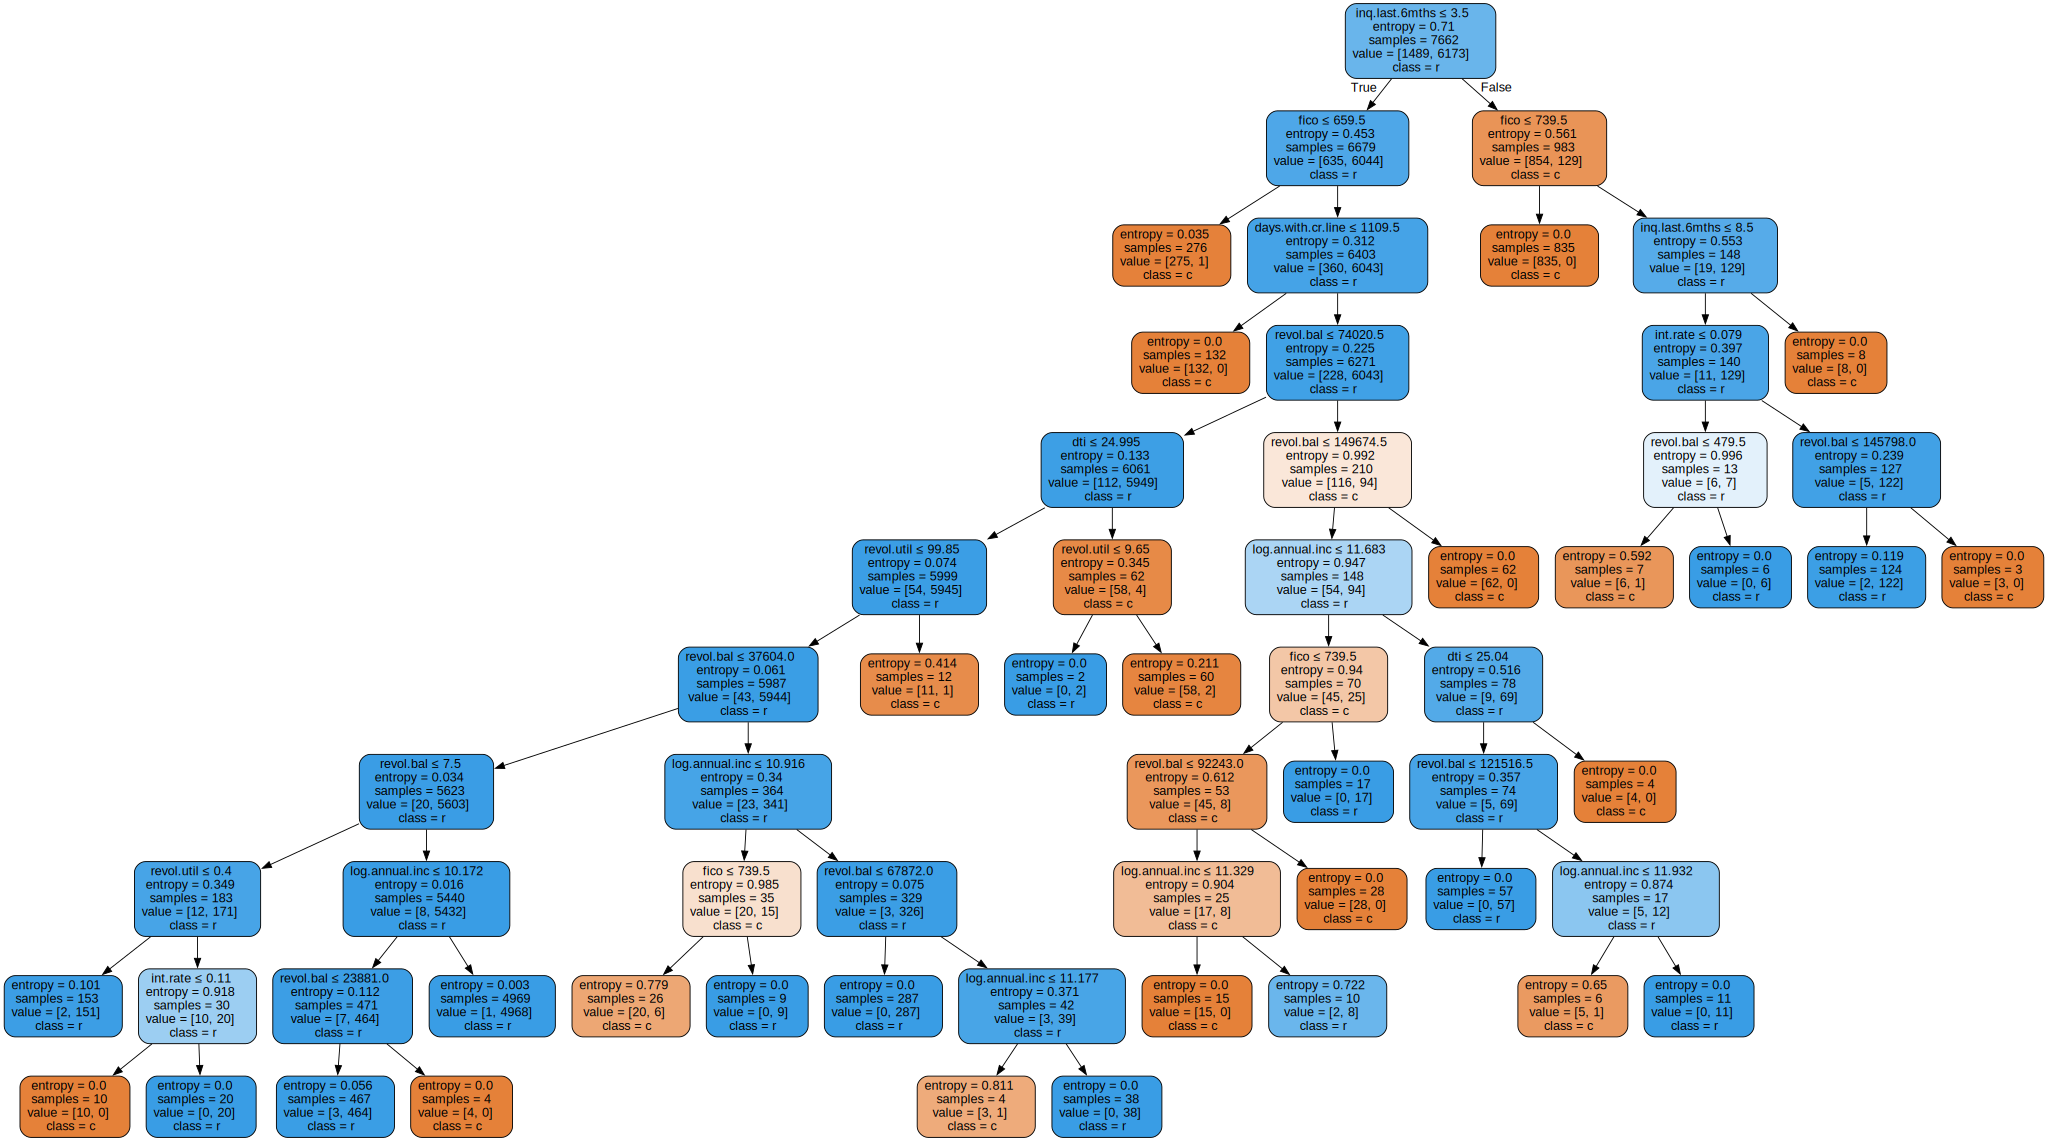

In [35]:
import graphviz
from sklearn import tree

def plot_tree(clf):
    dot_data = tree.export_graphviz(clf, out_file=None,
                       feature_names=list(X_train.columns),
                       class_names=y_train.name,
                       filled=True, rounded=True,
                       special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph

graph_dt = plot_tree(improved_dt_clf)
graph_dt

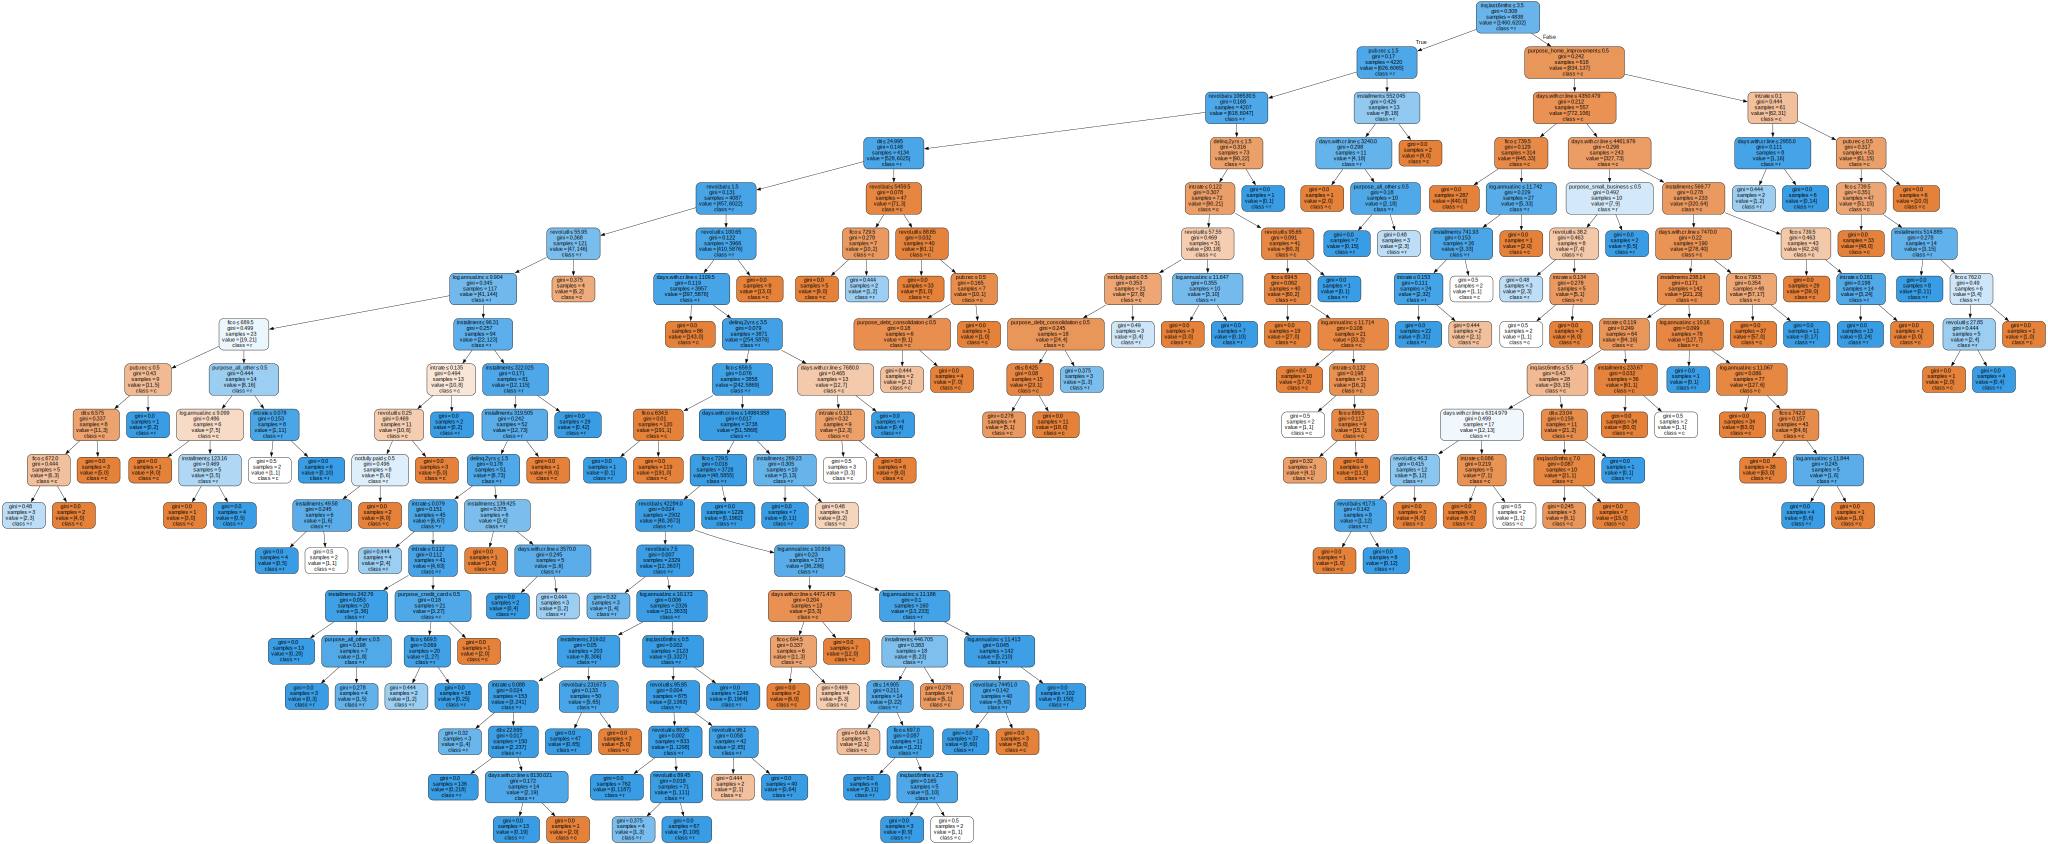

In [36]:
random_rf_tree = improved_rf_clf.estimators_[np.random.choice(len(improved_rf_clf.estimators_))]
graph_rf = plot_tree(random_rf_tree)
graph_rf

In [42]:
print('DT max depth:', improved_dt_clf.tree_.max_depth)
print('RF max depth:', max([estimator.tree_.max_depth for estimator in improved_rf_clf.estimators_]))

DT max depth: 10
RF max depth: 30


### Questions
1. How did the DT compare to the RF in performance? Why?
    - DT performed slightly better than RF in this case, but the difference is small and it is not something unexpected because RF's are used to get more generalized data.
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - Max depth in DT appeared to be smaller than in RF. Random forests are better able to handle overfitting due to the ensemble of trees, thats probably why in grid search it chose higher max_depth parameter to achieve more complex model.
3. What is ensemble learning? What are its pros and cons?

    - Ensemble learning is a machine learning technique that combines multiple models to improve the accuracy and robustness of predictions.
    
    Pros:
    
    1) Ensemble learning can improve the accuracy of predictions by combining the strengths of multiple models.
    
    2) Ensemble learning is a flexible technique that can be applied to a wide range of machine learning problems.
    
    Cons:
    
    1) Ensemble learning can be computationally expensive.
    
    2) Ensemble learning can be prone to overfitting if not properly implemented.
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods. Which of these categories does RF fall under?

    **Boosting methods:**
    
    1) Adaptive Boosting: algorithm that works by training weak classifiers on subsets of the data and increasing the weights of misclassified samples at each iteration.
    
    2) Gradient Boosting: algorithm that works by adding new models to the ensemble, with each new model attempting to correct the errors of the previous ones.
    
    **Bagging methods:**
    
    1) Random Forest: algorithm that works by building multiple decision trees on random subsets of the data and combining their predictions.
    
    2) Bootstrap Aggregation: general bagging algorithm that works by training multiple models on different subsets of the data and combining their predictions.
    
    **Random Forest falls under the category of bagging methods.**
    
    